In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import pandas as pd
#Check GPU activation
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import time
import requests as req
import json
import pickle
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from keras import initializers

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

C:\Users\ckf30\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ckf30\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ckf30\Anaconda3\envs\tensorflow_gpuenv\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ckf30\Anaconda3\envs\tensorf

In [245]:
#from numpy.random import seed
#seed(1)
#from tensorflow import set_random_seed
#set_random_seed(2)

In [5]:
#input parameter
window_length = 240
epochs = 300
test_samples = 117600

In [6]:
#All subjects
dfa = pd.concat([pd.read_csv(f,header=None) for f in glob.glob('C:/kai2020spring/truncacc/*.csv')], ignore_index = True)
y=np.array(dfa[1][0:588000])

#Normalize the data
#from sklearn import preprocessing
#y=np.reshape(y, (len(y),1))
#preprocessing.normalize(y)
import statistics as stats
y=(y-min(y))/(max(y)-min(y))


#y_all=np.array(dfa[0])
x_test = y[-test_samples:]
x_train = y[:-test_samples]

#Reshape x_train
#Reshape x_test
x_train=np.array(np.reshape(x_train,(-1,1960)))
x_test=np.array(np.reshape(x_test,(-1,490)))
x_all=np.array(np.reshape(y,(-1,2450)))
#y_all=np.array(np.reshape(y_all,(-1,2352)))
print('x_train.shape:',x_train.shape, "x_test.shape:",x_test.shape,"x_all.shape:",x_all.shape)
x_all=np.array(np.reshape(x_all,(x_all.shape[1],x_all.shape[0],1)))
x_train=np.reshape(x_train,(x_train.shape[1],x_train.shape[0],1))
x_test=np.reshape(x_test,(x_test.shape[1],x_test.shape[0],1))
#y_all=np.array(np.reshape(y_all,(y_all.shape[1],y_all.shape[0],1)))
x_train.shape

x_train.shape: (240, 1960) x_test.shape: (240, 490) x_all.shape: (240, 2450)


(1960, 240, 1)

In [7]:
#Checking
import glob
files = glob.glob ('C:/kai2020spring/truncacc/*.csv')
for myFile in files:
    print(myFile)

C:/kai2020spring/truncacc\1.csv
C:/kai2020spring/truncacc\10.csv
C:/kai2020spring/truncacc\11.csv
C:/kai2020spring/truncacc\12.csv
C:/kai2020spring/truncacc\13.csv
C:/kai2020spring/truncacc\14.csv
C:/kai2020spring/truncacc\15.csv
C:/kai2020spring/truncacc\16.csv
C:/kai2020spring/truncacc\17.csv
C:/kai2020spring/truncacc\18.csv
C:/kai2020spring/truncacc\19.csv
C:/kai2020spring/truncacc\2.csv
C:/kai2020spring/truncacc\20.csv
C:/kai2020spring/truncacc\21.csv
C:/kai2020spring/truncacc\22.csv
C:/kai2020spring/truncacc\23.csv
C:/kai2020spring/truncacc\24.csv
C:/kai2020spring/truncacc\25.csv
C:/kai2020spring/truncacc\26.csv
C:/kai2020spring/truncacc\27.csv
C:/kai2020spring/truncacc\28.csv
C:/kai2020spring/truncacc\29.csv
C:/kai2020spring/truncacc\3.csv
C:/kai2020spring/truncacc\30.csv
C:/kai2020spring/truncacc\31.csv
C:/kai2020spring/truncacc\32.csv
C:/kai2020spring/truncacc\33.csv
C:/kai2020spring/truncacc\34.csv
C:/kai2020spring/truncacc\35.csv
C:/kai2020spring/truncacc\36.csv
C:/kai2020spr

In [8]:
from keras import optimizers
adam=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False,epsilon=None, decay=0.0)#Convolutional Autodencoder


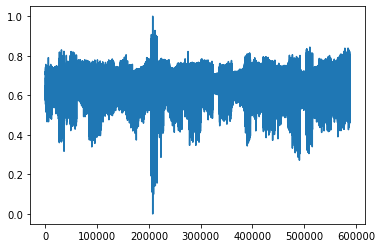

In [9]:
plt.plot(y)

In [10]:
#Convolutional Autodencoder
input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="tanh", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2,padding="same")(x) # 5 dims



x = Conv1D(1, 3, activation="tanh", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2,padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)



x = Conv1D(1, 3, activation="tanh", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims



x = Conv1D(16, 3, activation='tanh',padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 240, 16)           64        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 120, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 120, 1)            49        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 60, 1)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 60, 1)             4         
_________________________________________________________________
up_sampling1d_1 (UpSampling1 (None, 120, 1)            0         
__________

In [11]:
autoencoder.compile(optimizer=adam, loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=100,
                shuffle=False,
                validation_data=(x_test, x_test))

encoder = Model(input_window, encoded)
decoded_data = autoencoder.predict(x_test)

Instructions for updating:
Use tf.cast instead.
Train on 1960 samples, validate on 490 samples
Epoch 1/300
1960/1960 [==============================] - 1s 303us/step - loss: 0.6862 - val_loss: 0.6749
Epoch 2/300
1960/1960 [==============================] - 0s 231us/step - loss: 0.6640 - val_loss: 0.6558
Epoch 3/300
1960/1960 [==============================] - 0s 228us/step - loss: 0.6481 - val_loss: 0.6435
Epoch 4/300
1960/1960 [==============================] - 0s 232us/step - loss: 0.6388 - val_loss: 0.6372
Epoch 5/300
1960/1960 [==============================] - 0s 226us/step - loss: 0.6346 - val_loss: 0.6349
Epoch 6/300
1960/1960 [==============================] - 0s 229us/step - loss: 0.6333 - val_loss: 0.6342
Epoch 7/300
1960/1960 [==============================] - 0s 230us/step - loss: 0.6330 - val_loss: 0.6341
Epoch 8/300
1960/1960 [==============================] - 0s 230us/step - loss: 0.6329 - val_loss: 0.6341
Epoch 9/300
1960/1960 [==============================] - 0s 236us

1960/1960 [==============================] - 1s 339us/step - loss: 0.6291 - val_loss: 0.6293
Epoch 76/300
1960/1960 [==============================] - 1s 422us/step - loss: 0.6290 - val_loss: 0.6292
Epoch 77/300
1960/1960 [==============================] - 0s 238us/step - loss: 0.6290 - val_loss: 0.6292
Epoch 78/300
1960/1960 [==============================] - 0s 231us/step - loss: 0.6290 - val_loss: 0.6292
Epoch 79/300
1960/1960 [==============================] - 0s 230us/step - loss: 0.6289 - val_loss: 0.6291
Epoch 80/300
1960/1960 [==============================] - 0s 248us/step - loss: 0.6289 - val_loss: 0.6291
Epoch 81/300
1960/1960 [==============================] - 0s 248us/step - loss: 0.6289 - val_loss: 0.6290
Epoch 82/300
1960/1960 [==============================] - 0s 251us/step - loss: 0.6288 - val_loss: 0.6290
Epoch 83/300
1960/1960 [==============================] - 0s 254us/step - loss: 0.6288 - val_loss: 0.6289
Epoch 84/300
1960/1960 [==============================] - 1

Epoch 152/300
1960/1960 [==============================] - 0s 252us/step - loss: 0.6274 - val_loss: 0.6272
Epoch 153/300
1960/1960 [==============================] - 1s 255us/step - loss: 0.6274 - val_loss: 0.6272
Epoch 154/300
1960/1960 [==============================] - 1s 255us/step - loss: 0.6274 - val_loss: 0.6272
Epoch 155/300
1960/1960 [==============================] - 0s 254us/step - loss: 0.6274 - val_loss: 0.6271
Epoch 156/300
1960/1960 [==============================] - 1s 270us/step - loss: 0.6273 - val_loss: 0.6271
Epoch 157/300
1960/1960 [==============================] - 1s 283us/step - loss: 0.6273 - val_loss: 0.6271
Epoch 158/300
1960/1960 [==============================] - 1s 389us/step - loss: 0.6273 - val_loss: 0.6271
Epoch 159/300
1960/1960 [==============================] - 1s 291us/step - loss: 0.6273 - val_loss: 0.6270
Epoch 160/300
1960/1960 [==============================] - 1s 271us/step - loss: 0.6273 - val_loss: 0.6270
Epoch 161/300
1960/1960 [============

In [12]:
#PLot Loss Function
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"],color='g')
    #plt.title("Train loss")
    #ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"],color='r')
    plt.title("Train loss=green; Test loss=red")

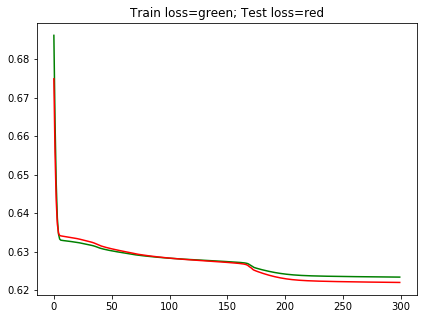

In [13]:
plot_history(history)

490/490 [==============================] - 0s 145us/step
0.6220305440377216


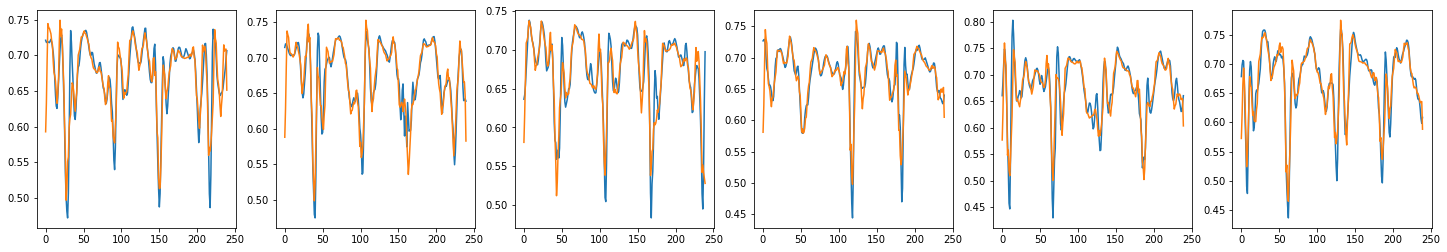

In [15]:
plt.figure(figsize=(25,4))

s0=autoencoder.evaluate(x_test, x_test)
print(s0)

plt.subplot(1,6,1)
plt.plot(x_test[0])
plt.plot(decoded_data[0])

plt.subplot(1,6,2)
plt.plot(x_test[1])
plt.plot(decoded_data[1])

plt.subplot(1,6,3)
plt.plot(x_test[2])
plt.plot(decoded_data[2])

plt.subplot(1,6,4)
plt.plot(x_test[3])
plt.plot(decoded_data[3])

plt.subplot(1,6,5)
plt.plot(x_test[4])
plt.plot(decoded_data[4])

plt.subplot(1,6,6)
plt.plot(x_test[5])
plt.plot(decoded_data[5])

In [16]:
latent_feat=encoder.predict(x_test)
#latent_feat1=np.reshape(latent_feat,(12,63))

#latent_feat1=np.reshape(latent_feat,(588,25))
latent_feat1=np.reshape(latent_feat,(490,60))

print("latent_feat.shape",latent_feat.shape,"latent_feat1.shape",latent_feat1.shape)

latent_feat.shape (490, 60, 1) latent_feat1.shape (490, 60)


In [17]:
autoencoder.compile(optimizer=adam, loss='binary_crossentropy')
history = autoencoder.fit(x_all, x_all,
                epochs=epochs,
                batch_size=15,
                shuffle=False)
                #validation_data=(x_test, x_test))

encoder1 = Model(input_window, encoded)


Epoch 1/300
2450/2450 [==============================] - 2s 696us/step - loss: 0.6231
Epoch 2/300
2450/2450 [==============================] - 2s 622us/step - loss: 0.6231
Epoch 3/300
2450/2450 [==============================] - 2s 624us/step - loss: 0.6230
Epoch 4/300
2450/2450 [==============================] - 2s 626us/step - loss: 0.6230
Epoch 5/300
2450/2450 [==============================] - 2s 619us/step - loss: 0.6230
Epoch 6/300
2450/2450 [==============================] - 2s 616us/step - loss: 0.6230
Epoch 7/300
2450/2450 [==============================] - 2s 620us/step - loss: 0.6229
Epoch 8/300
2450/2450 [==============================] - 2s 618us/step - loss: 0.6229
Epoch 9/300
2450/2450 [==============================] - 2s 621us/step - loss: 0.6229
Epoch 10/300
2450/2450 [==============================] - 2s 625us/step - loss: 0.6229
Epoch 11/300
2450/2450 [==============================] - 2s 624us/step - loss: 0.6229
Epoch 12/300
2450/2450 [============================

2450/2450 [==============================] - 2s 796us/step - loss: 0.6225
Epoch 188/300
2450/2450 [==============================] - 2s 828us/step - loss: 0.6225
Epoch 189/300
2450/2450 [==============================] - 2s 911us/step - loss: 0.6225
Epoch 190/300
2450/2450 [==============================] - 2s 726us/step - loss: 0.6225
Epoch 191/300
2450/2450 [==============================] - 2s 703us/step - loss: 0.6225
Epoch 192/300
2450/2450 [==============================] - 2s 706us/step - loss: 0.6225
Epoch 193/300
2450/2450 [==============================] - 2s 713us/step - loss: 0.6225
Epoch 194/300
2450/2450 [==============================] - 2s 709us/step - loss: 0.6225
Epoch 195/300
2450/2450 [==============================] - 2s 705us/step - loss: 0.6225
Epoch 196/300
2450/2450 [==============================] - 2s 707us/step - loss: 0.6225
Epoch 197/300
2450/2450 [==============================] - 2s 713us/step - loss: 0.6225
Epoch 198/300
2450/2450 [=====================

Epoch 280/300
2450/2450 [==============================] - 2s 811us/step - loss: 0.6224
Epoch 281/300
2450/2450 [==============================] - 2s 704us/step - loss: 0.6224
Epoch 282/300
2450/2450 [==============================] - 2s 705us/step - loss: 0.6224
Epoch 283/300
2450/2450 [==============================] - 2s 707us/step - loss: 0.6224
Epoch 284/300
2450/2450 [==============================] - 2s 722us/step - loss: 0.6224
Epoch 285/300
2450/2450 [==============================] - 2s 736us/step - loss: 0.6224
Epoch 286/300
2450/2450 [==============================] - 2s 705us/step - loss: 0.6224
Epoch 287/300
2450/2450 [==============================] - 2s 735us/step - loss: 0.6224
Epoch 288/300
2450/2450 [==============================] - 2s 749us/step - loss: 0.6224
Epoch 289/300
2450/2450 [==============================] - 2s 707us/step - loss: 0.6224
Epoch 290/300
2450/2450 [==============================] - 2s 708us/step - loss: 0.6224
Epoch 291/300
2450/2450 [=======

In [260]:
feat=encoder.predict(x_all)
feat1=np.reshape(feat,(2450,30))
feat1.shape
last12_feat1=feat1[1960:,]

In [262]:
all_corcoef=[]
for i in range(0,30):
    cori=np.corrcoef(latent_feat1[:,i],last12_feat1[:,i])[0,1]
    all_corcoef.append(cori)
print(all_corcoef)

[0.6835299733177173, 0.7682906154149642, 0.7366018816803342, 0.6866030755920342, 0.7713106074942527, 0.7469418929426028, 0.7434934223185886, 0.7718223687325096, 0.7189952147632128, 0.76321360428808, 0.7159659001690164, 0.7378474753143641, 0.7639358644498616, 0.7713419300355083, 0.7420301423658617, 0.7421021967343396, 0.7668080447901998, 0.7276428609843947, 0.7730433779647822, 0.7327117625448669, 0.7572141116131217, 0.7677226384383509, 0.735652033859377, 0.7630156481106672, 0.7470525264051942, 0.7511141022043323, 0.7457584920961101, 0.7513333157364389, 0.7359761136393949, 0.9260060100702806]


In [185]:
feat1.shape

(2450, 30)

In [188]:
np.savetxt("C:/kai2020spring/To_Huynsoo/y_all_30_1feats.csv",feat1, delimiter=",")

In [ ]:
allfeat=encoder.predict(y_all)
allfeat.shape
allfeat=np.reshape(allfeat,(2352,25))
allfeat.shape

In [37]:
np.savetxt("C:/kai2020spring/To_Huynsoo/all_feat.csv",allfeat, delimiter=",")